In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from mpl_toolkits.mplot3d import Axes3D 
import plotly.graph_objects as go

import scienceplots
plt.style.use('science')
plt.style.use(['no-latex'])

savepath = "results/P2Q3/"

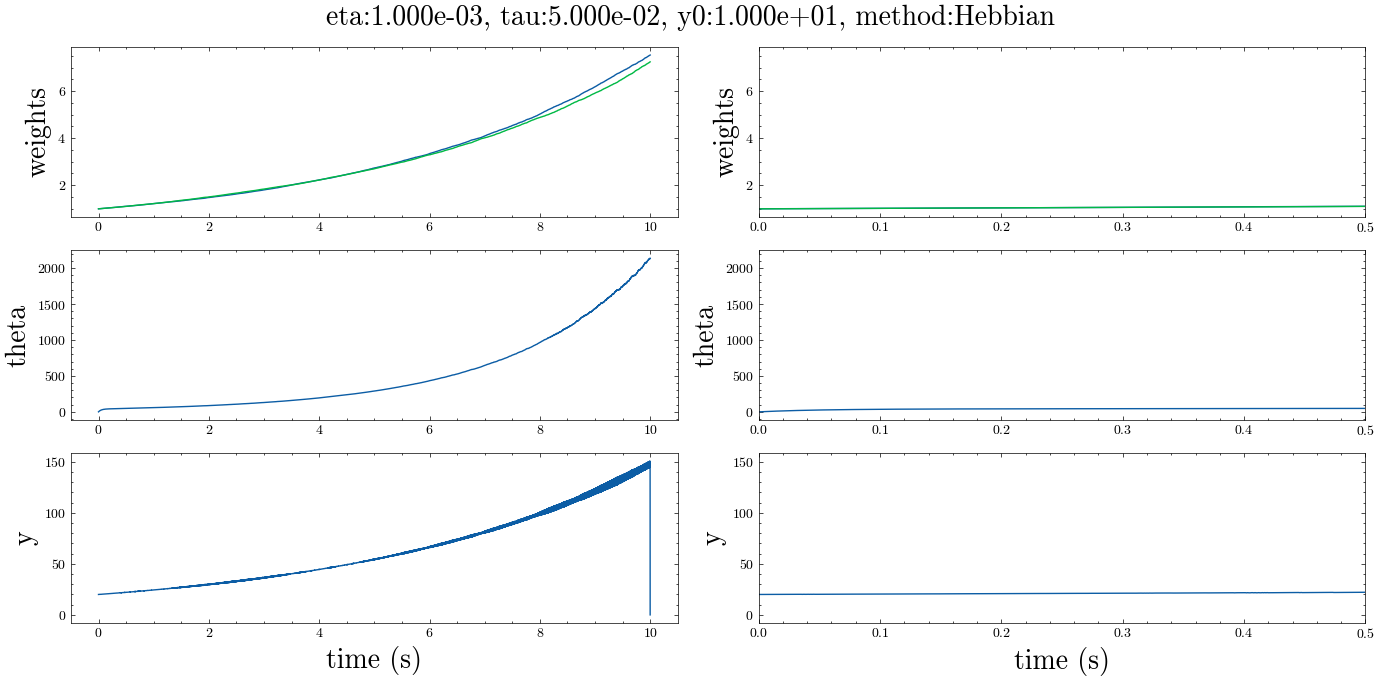

In [ ]:
T = 10
dt = 0.001
eta = 10**-3 * 1.0
tau = 0.050 * 1.0
y0 = 10.0 * 1.0

method = "BCM"
seed = np.random.randint(0, 10000)
np.random.seed(seed)

time = np.arange(0, T, dt)
lt = len(time)
x1 = np.array([20, 0])
x2 = np.array([0, 20])
p_x = 0.5
weight_scale = 1.0

wt = np.zeros((2, lt))
# wt[:, 0] = np.random.rand(2) * weight_scale
wt[:, 0] = np.array([1.0, 1.0]) * weight_scale
yt = np.zeros(lt)
thetat = yt*1

for tt in range(lt - 1):
    if np.random.rand() > p_x:
        xt = x1 * 1
    else:
        xt = x2 * 1

    yt[tt] = wt[:, tt] @ xt
    # Adaptive threshold
    thetat[tt + 1] = thetat[tt] + dt / tau * (-thetat[tt] + yt[tt] ** 2 / y0)
    
    if method == "BCM":
        # BCM weight dynamics
        wt[:, tt+1] = wt[:, tt] + dt * eta * xt * yt[tt] * (yt[tt] - thetat[tt])
    elif method == "Hebbian":
        # Hebbian alternative (disabled)
        wt[:, tt + 1] = wt[:, tt] + dt * eta * xt * yt[tt]
    else:
        raise ValueError("Unknown method: {}".format(method))

    wt[:, tt+1] = np.maximum(wt[:, tt+1], 0.0)

# plotting
fig, ax = plt.subplots(3, 2, figsize=(7*2, 7))
for i in range(2):
    ax[0, i].plot(time, wt.T)
    ax[0, i].set_ylabel('weights', fontsize=20)
    ax[1, i].plot(time, thetat)
    ax[1, i].set_ylabel('theta', fontsize=20)
    ax[2, i].plot(time, yt)
    ax[2, i].set_xlabel('time (s)', fontsize=20)
    ax[2, i].set_ylabel('y', fontsize=20)
for j in range(3):
    ax[j, 1].set_xlim([0, 0.5])  # first 500 times steps

fig.suptitle(f"eta:{eta:.3e}, tau:{tau:.3e}, y0:{y0:.3e}, method:{method}", fontsize=20)
fig.tight_layout()
fig.savefig(savepath + f'P2Q1_{method}_seed{seed}.png', dpi=1000, bbox_inches='tight')

#### 3.1

1. Early on, $\theta(0)=0$, so the very first updates are poteniating ($y > \theta \rightarrow \text{LTP}$), which quickly raises $y$ and therefore $\theta$. Once $\theta$ catchs up, the typical state becomes $y < \theta$ and both weights depress until symmetry breaks. 
2. Both inputs are mutually exclusive, fluctuations eventually push one synapse into an LTP regime more often; it wins while the other is driven to 0 through competition & specialization. 

#### 3.2
1. Weights: symmetry-breaking; one weight grows to $\mathcal{O}(1)$, the other decays to $0$. 
2. Threshold: rapid rise (due to initial large $y^2/y_0$), then a slower track of the running $y^2$. 
3. Output $y$: after specialization, $y \approx 20 w_{\text{winner}}$ when its pattern is shown, and $\approx 0$ otherwise. 

#### 3.3 
1. Different seeds lead to either $w_1$ or $w_2$ winning.
2. Zoomed view: a fast $\theta$ increase followed by depression of both weights, then divergence begins. 

#### 3.4
1. $\eta$: larger $\eta$ indicates fast competition but risk of overshoot/instability; smaller $\eta$ indicates slow learning. 
2. sets the homeostatic set point via $\theta \approx \langle y^2 \rangle / y_0$. Increasing $y_0$ lowers $\theta$, indicating potentiation easier and higher steady weights; decreasing $y_0$ raises $\theta$, indicating more depression. 
3. $\tau$: averaging window for $\theta$. Small $\tau \rightarrow \theta$ tracks $y^2$ too closely (can osciallate, fragile); large $\tau \rightarrow$ smoother, slower hemeostatis (slower competition and adaptation). 

#### 3.5
1. Hebbian: with nonnegative inputs, both grow without bound (no competition, no target-rate control) unless you add separate normalization/decay.
2. BCM advantages: stable specialization/competition; built-in homeostasis that keeps activity near a target; avoids runaway growth.
3. Disadvantage: need an extra state $\theta$ and parameters $(\tau, y_0)$ that must be tuned; behavior can be sensitive if $\tau$ or $\eta$ are poorly chosen. 
